<a href="https://colab.research.google.com/github/Bertaalcolea/Collagen_studies/blob/main/dECM_NaClvsKCl.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Rows parsed: 6516
Wells parsed: 27


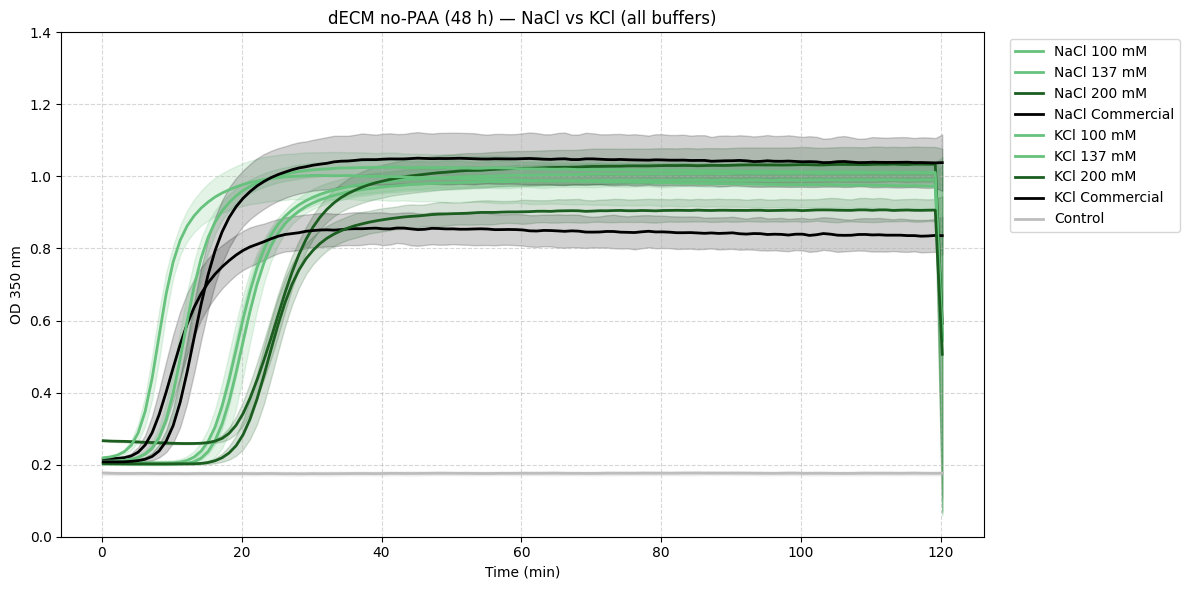

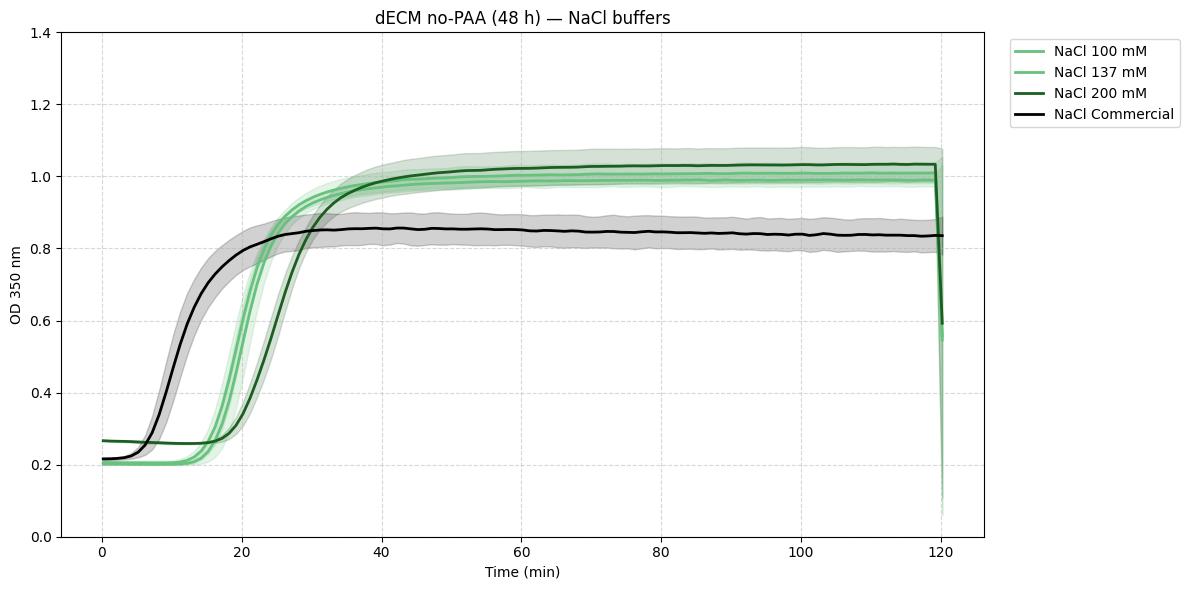

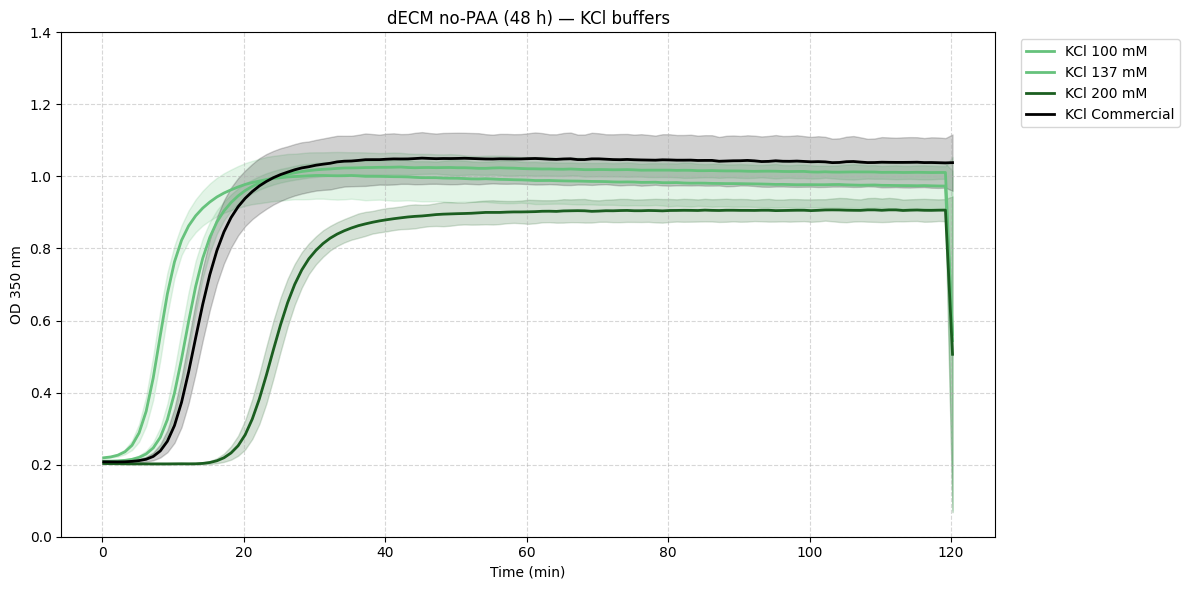

In [33]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt

# =========================
# 1) Cargar Excel (Epoch format)
# =========================
file_path = "/content/dECM-No-PAA_NaCl_KCl_Study1.xlsx"
df = pd.read_excel(file_path, sheet_name=0, header=None)

# =========================
# 2) Parser: extraer (time_min, well, OD)
#    Busca filas tipo: "350 - Time X (0:03:12)"
#    y lee la "placa" A–E, cols 1–6 (en el excel están en columnas 2..7)
# =========================
def hms_to_min(hms: str) -> float:
    # hms tipo "0:03:12" o "00:03:12"
    parts = hms.split(":")
    if len(parts) == 3:
        h, m, s = map(int, parts)
    elif len(parts) == 2:
        h = 0
        m, s = map(int, parts)
    else:
        return np.nan
    return h*60 + m + s/60

rows = []
time_pat = re.compile(r"350\s*-\s*Time\s*\d+\s*\(([\d:]+)\)")

for i in range(len(df)):
    v = df.iloc[i, 0]
    if isinstance(v, str):
        m = time_pat.search(v)
        if m:
            t_min = hms_to_min(m.group(1))

            # La tabla de placa empieza unas filas después:
            # en tu archivo: header de columnas (1..10) aparece y luego A,B,C,D,E...
            # Lo más robusto: buscamos las filas A-E inmediatamente debajo del bloque
            # y leemos columnas 2..7 (que corresponden a 1..6)
            for j in range(i, min(i+20, len(df))):
                row_letter = df.iloc[j, 1]
                if row_letter in list("ABCDE"):
                    for col_num in range(1, 7):  # 1..6
                        val = df.iloc[j, 1 + col_num]  # col 2..7 en excel
                        if pd.notna(val):
                            well = f"{row_letter}{col_num}"
                            rows.append((t_min, well, float(val)))

long_df = pd.DataFrame(rows, columns=["time_min", "well", "OD"])
print("Rows parsed:", len(long_df))
print("Wells parsed:", long_df["well"].nunique())

# =========================
# 3) Mapeo de condiciones
# =========================
cond_map = {
    # NaCl
    "A1":"NaCl 100 mM","A2":"NaCl 100 mM","A3":"NaCl 100 mM",
    "B1":"NaCl 137 mM","B2":"NaCl 137 mM","B3":"NaCl 137 mM",
    "C1":"NaCl 200 mM","C2":"NaCl 200 mM","C3":"NaCl 200 mM",
    "D1":"NaCl Commercial","D2":"NaCl Commercial","D3":"NaCl Commercial",

    # KCl
    "A4":"KCl 100 mM","A5":"KCl 100 mM","A6":"KCl 100 mM",
    "B4":"KCl 137 mM","B5":"KCl 137 mM","B6":"KCl 137 mM",
    "C4":"KCl 200 mM","C5":"KCl 200 mM","C6":"KCl 200 mM",
    "D4":"KCl Commercial","D5":"KCl Commercial","D6":"KCl Commercial",

    # Control
    "E1":"Control","E2":"Control","E3":"Control",
}

long_df["cond"] = long_df["well"].map(cond_map)
long_df = long_df.dropna(subset=["cond"])

# =========================
# 4) Summary (mean ± sd)
# =========================
summary = (
    long_df.groupby(["cond","time_min"])["OD"]
    .agg(["mean","std"])
    .reset_index()
)

# =========================
# 5) Colores: 2 verdes + negro + gris
# =========================
GREEN_APPLE = "#66c27c"   # verde manzana
GREEN_DARK  = "#1b5e20"   # verde oscuro

color_map = {
    "NaCl 100 mM": GREEN_APPLE,
    "NaCl 137 mM": GREEN_APPLE,
    "NaCl 200 mM": GREEN_DARK,
    "NaCl Commercial": "black",

    "KCl 100 mM": GREEN_APPLE,
    "KCl 137 mM": GREEN_APPLE,
    "KCl 200 mM": GREEN_DARK,
    "KCl Commercial": "black",

    "Control": "#bdbdbd",
}

# =========================
# 6) Plot helper
# =========================
def plot_gelification(df_plot, title, y_lim=(0, 1.4), x_lim=(0, 120)):
    plt.figure(figsize=(12,6))

    order = [
        "NaCl 100 mM","NaCl 137 mM","NaCl 200 mM","NaCl Commercial",
        "KCl 100 mM","KCl 137 mM","KCl 200 mM","KCl Commercial",
        "Control"
    ]
    present = [c for c in order if c in df_plot["cond"].unique()]

    for cond in present:
        sub = df_plot[df_plot["cond"] == cond].sort_values("time_min")
        plt.plot(sub["time_min"], sub["mean"], label=cond,
                 color=color_map.get(cond, "black"), linewidth=2)
        plt.fill_between(sub["time_min"],
                         sub["mean"] - sub["std"],
                         sub["mean"] + sub["std"],
                         color=color_map.get(cond, "black"),
                         alpha=0.18)

    plt.title(title)
    plt.xlabel("Time (min)")
    plt.ylabel("OD 350 nm")
    plt.ylim(*y_lim)
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.legend(bbox_to_anchor=(1.02,1), loc="upper left")
    plt.tight_layout()
    plt.show()

# =========================
# 7) Tres gráficas
# =========================
plot_gelification(summary, "dECM no-PAA (48 h) — NaCl vs KCl (all buffers)")

summary_nacl = summary[summary["cond"].str.contains("NaCl")]
plot_gelification(summary_nacl, "dECM no-PAA (48 h) — NaCl buffers")

summary_kcl = summary[summary["cond"].str.contains("KCl")]
plot_gelification(summary_kcl, "dECM no-PAA (48 h) — KCl buffers")


In [34]:
# Colores por SAL
GREEN_APPLE = "#66c27c"   # KCl
GREEN_DARK  = "#1b5e20"   # NaCl

salt_color = {
    "NaCl": GREEN_DARK,
    "KCl": GREEN_APPLE,
    "Control": "#bdbdbd"
}

# Estilos de línea por BUFFER
buffer_ls = {
    "100 mM": ":",
    "137 mM": "--",
    "200 mM": "-",
    "Commercial": "-.",
    "Control": "-"   # por si lo ploteas
}

def split_cond(cond):
    # "NaCl 100 mM" -> ("NaCl","100 mM")
    # "KCl Commercial" -> ("KCl","Commercial")
    if cond == "Control":
        return ("Control", "Control")
    parts = cond.split(" ", 1)
    salt = parts[0]
    buf  = parts[1] if len(parts) > 1 else ""
    return (salt, buf)


In [35]:
def plot_gelification(df_plot, title, y_lim=(0, 1.4),x_lim=(0, 120)):
    plt.figure(figsize=(12,6))

    # Orden bonito en leyenda
    order = [
        "NaCl 100 mM","NaCl 137 mM","NaCl 200 mM","NaCl Commercial",
        "KCl 100 mM","KCl 137 mM","KCl 200 mM","KCl Commercial",
        "Control"
    ]
    present = [c for c in order if c in df_plot["cond"].unique()]

    for cond in present:
        sub = df_plot[df_plot["cond"] == cond].sort_values("time_min")
        salt, buf = split_cond(cond)

        col = salt_color.get(salt, "black")
        ls  = buffer_ls.get(buf, "-")

        plt.plot(
            sub["time_min"], sub["mean"],
            label=cond,
            color=col,
            linestyle=ls,
            linewidth=2
        )
        plt.fill_between(
            sub["time_min"],
            sub["mean"] - sub["std"],
            sub["mean"] + sub["std"],
            color=col,
            alpha=0.18
        )

    plt.title(title)
    plt.xlabel("Time (min)")
    plt.ylabel("OD 350 nm")
    plt.ylim(*y_lim)
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.legend(bbox_to_anchor=(1.02,1), loc="upper left")
    plt.tight_layout()
    plt.show()


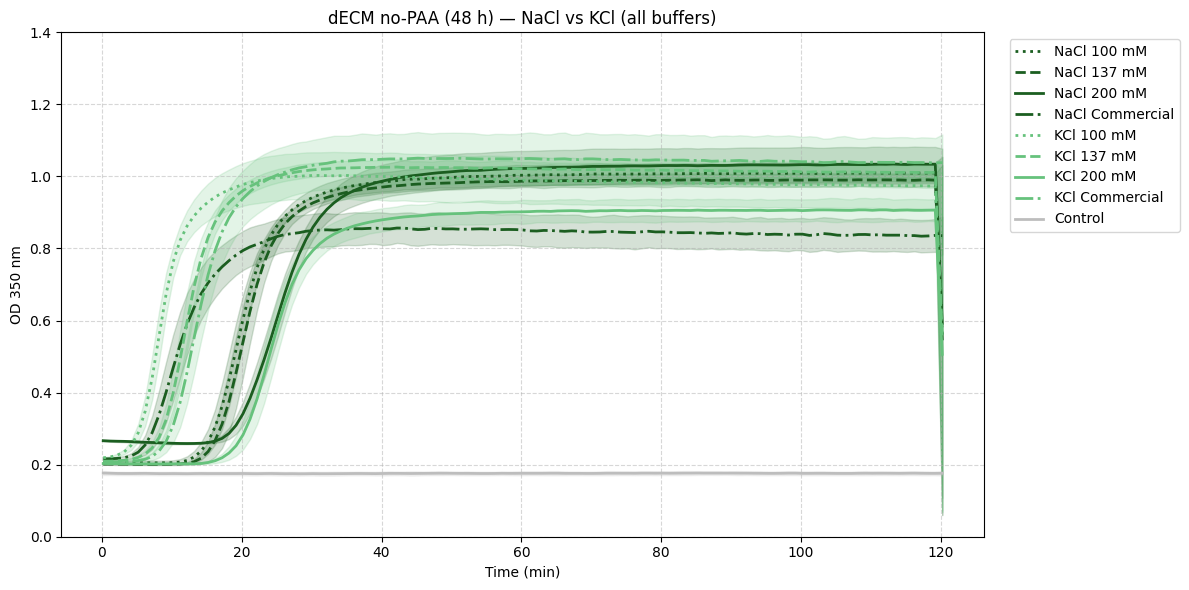

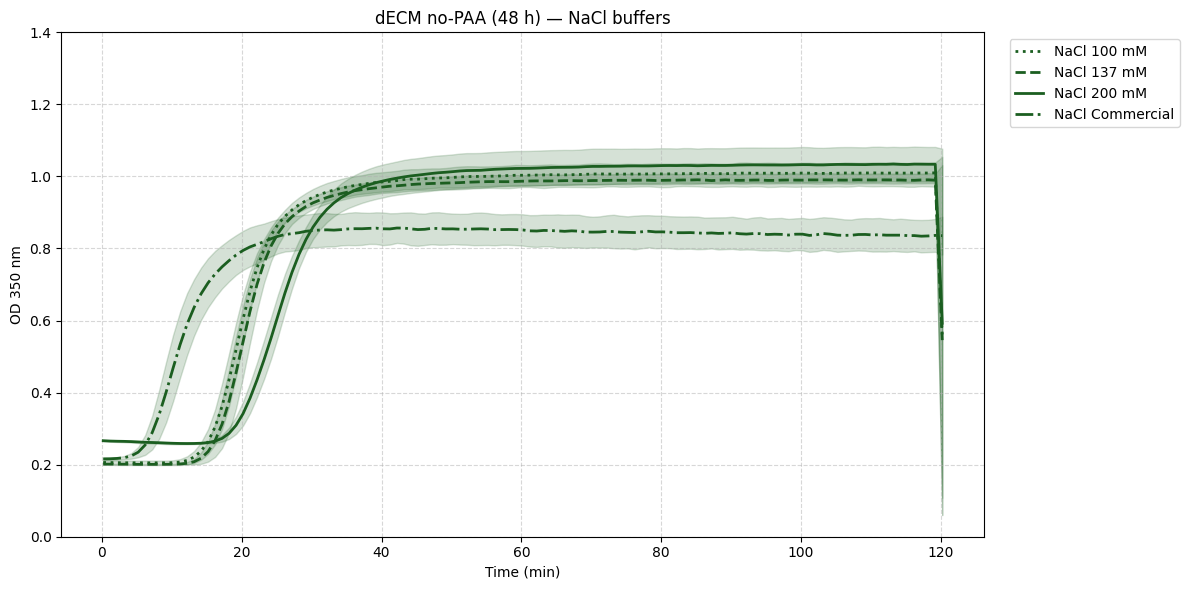

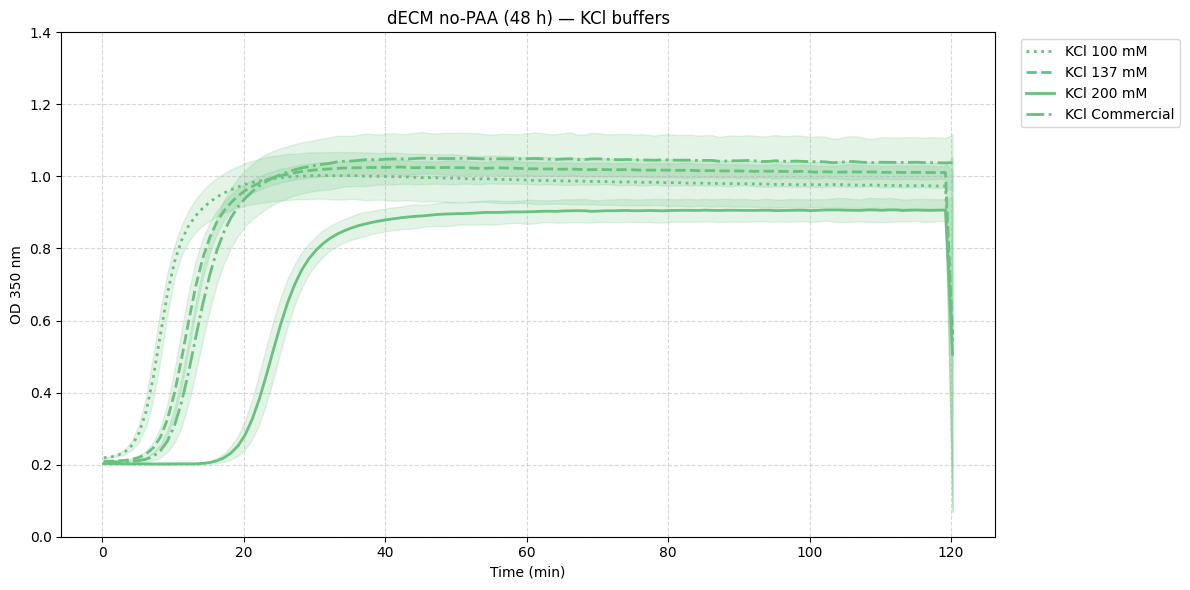

In [36]:
plot_gelification(summary, "dECM no-PAA (48 h) — NaCl vs KCl (all buffers)")

summary_nacl = summary[summary["cond"].str.contains("NaCl")]
plot_gelification(summary_nacl, "dECM no-PAA (48 h) — NaCl buffers")

summary_kcl = summary[summary["cond"].str.contains("KCl")]
plot_gelification(summary_kcl, "dECM no-PAA (48 h) — KCl buffers")


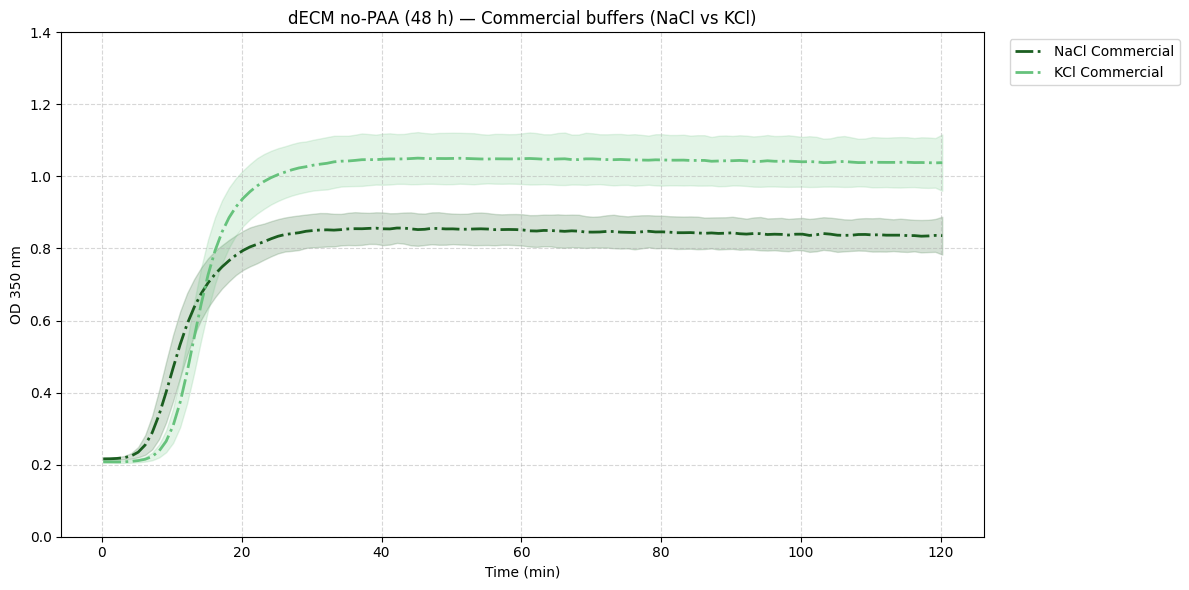

In [37]:
summary_commercial = summary[
    summary["cond"].isin(["NaCl Commercial", "KCl Commercial"])
]

plot_gelification(
    summary_commercial,
    "dECM no-PAA (48 h) — Commercial buffers (NaCl vs KCl)"
)


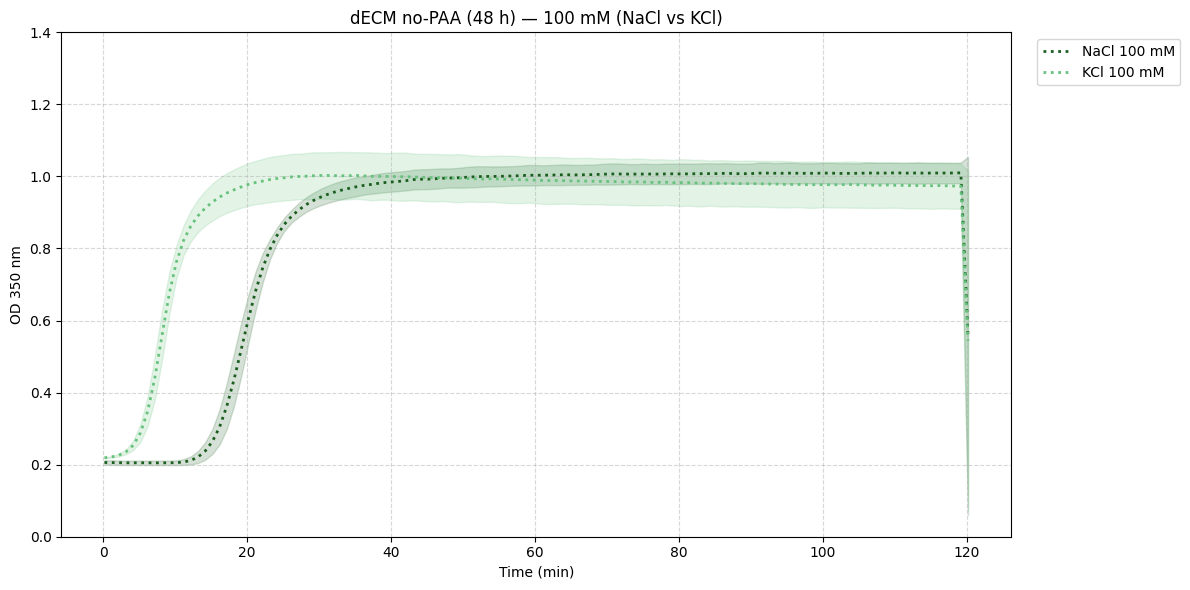

In [38]:
summary_100 = summary[
    summary["cond"].isin(["NaCl 100 mM", "KCl 100 mM"])
]

plot_gelification(
    summary_100,
    "dECM no-PAA (48 h) — 100 mM (NaCl vs KCl)"
)


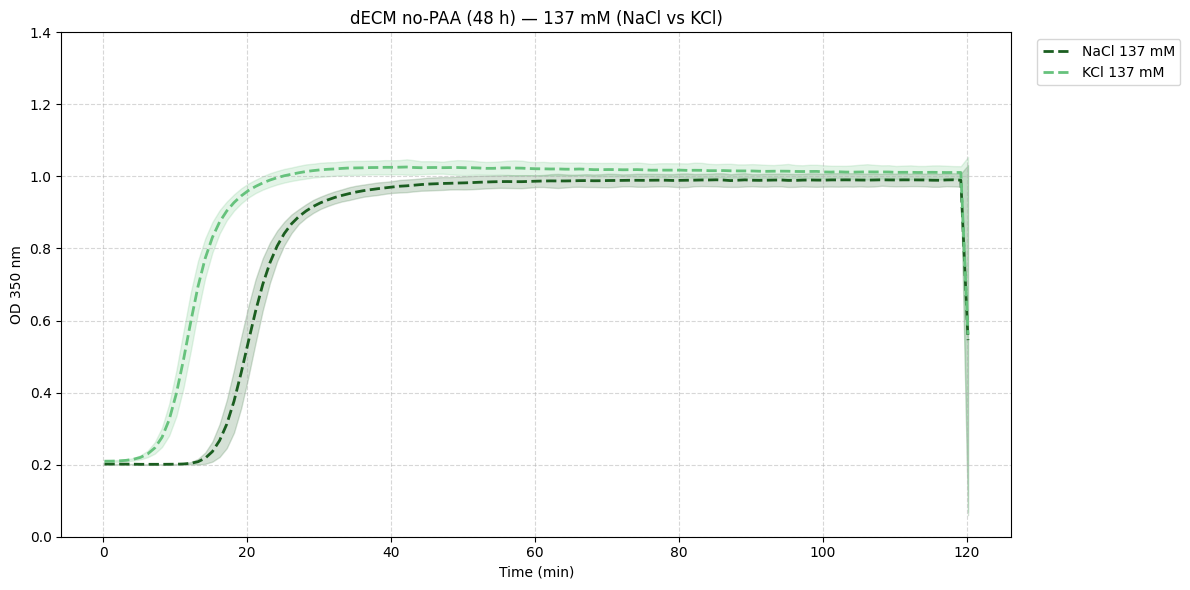

In [39]:
summary_137 = summary[
    summary["cond"].isin(["NaCl 137 mM", "KCl 137 mM"])
]

plot_gelification(
    summary_137,
    "dECM no-PAA (48 h) — 137 mM (NaCl vs KCl)"
)


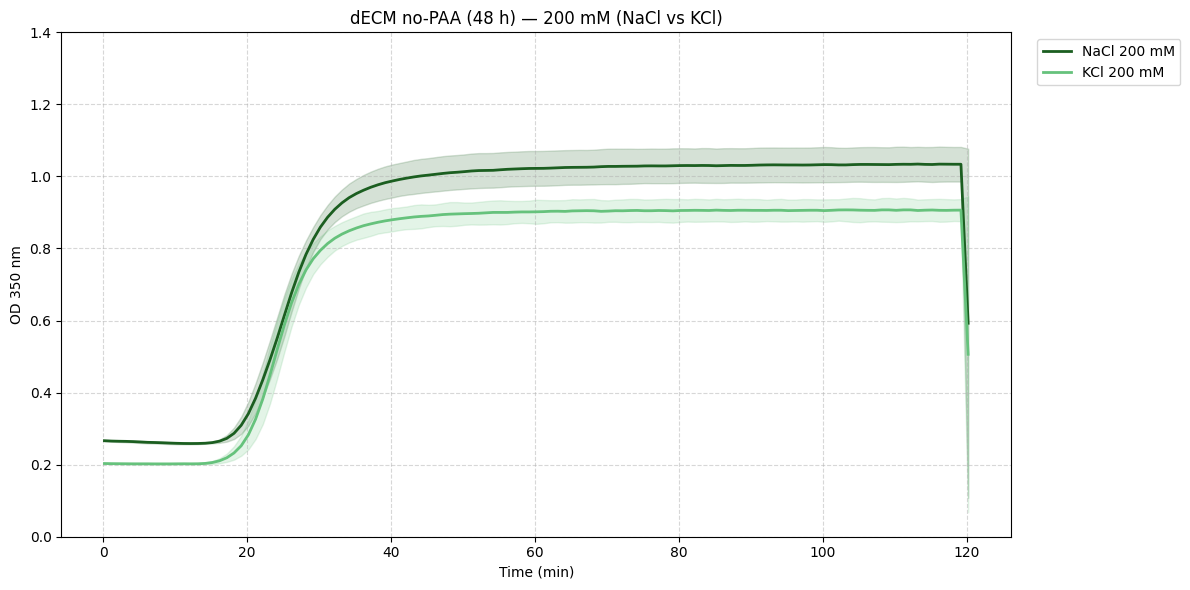

In [40]:
summary_200 = summary[
    summary["cond"].isin(["NaCl 200 mM", "KCl 200 mM"])
]

plot_gelification(
    summary_200,
    "dECM no-PAA (48 h) — 200 mM (NaCl vs KCl)"
)


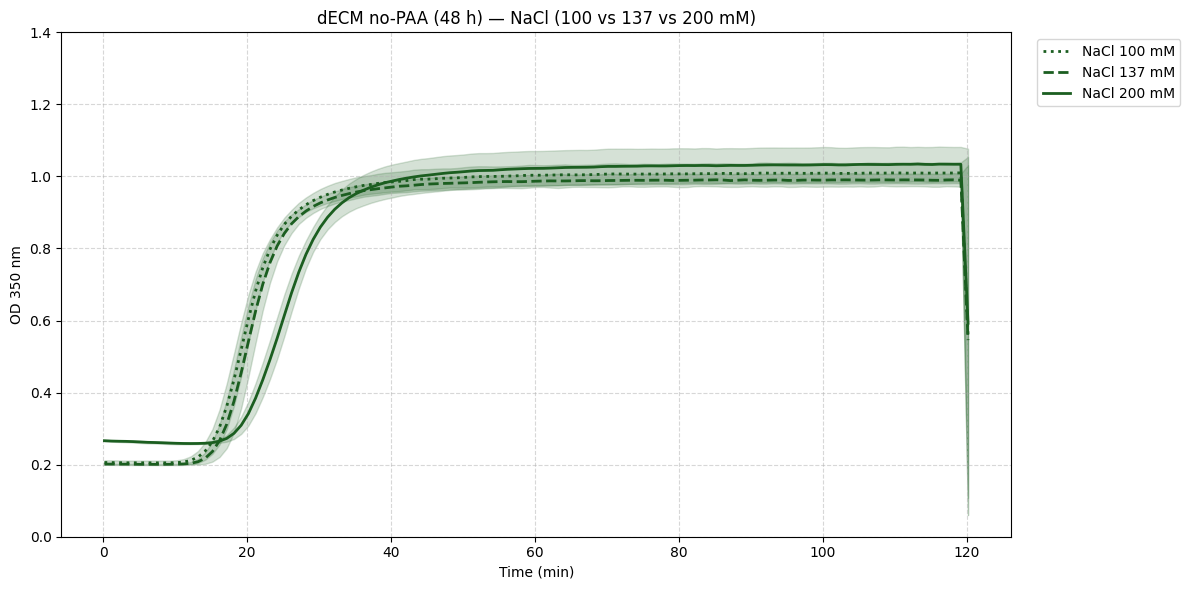

In [41]:
summary_nacl_conc = summary[
    summary["cond"].isin(["NaCl 100 mM", "NaCl 137 mM", "NaCl 200 mM"])
]

plot_gelification(
    summary_nacl_conc,
    "dECM no-PAA (48 h) — NaCl (100 vs 137 vs 200 mM)"
)


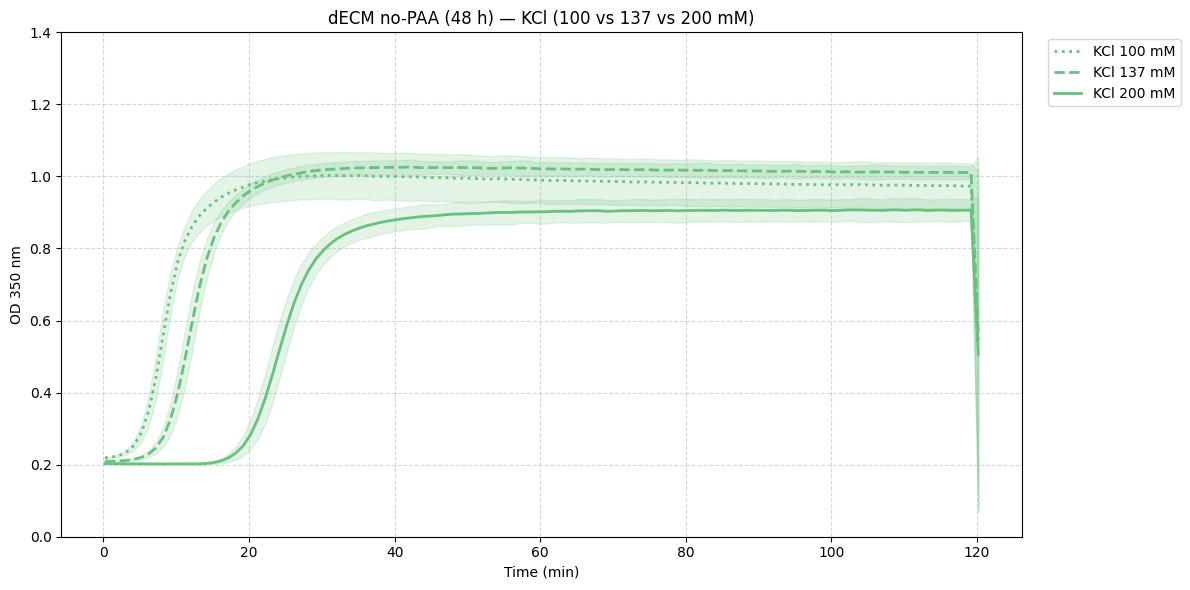

In [42]:
summary_kcl_conc = summary[
    summary["cond"].isin(["KCl 100 mM", "KCl 137 mM", "KCl 200 mM"])
]

plot_gelification(
    summary_kcl_conc,
    "dECM no-PAA (48 h) — KCl (100 vs 137 vs 200 mM)"
)


In [44]:
def conc_from_buffer(buf):
    # casos no numéricos
    if buf in ["Commercial", "Control", None]:
        return np.nan
    # solo si acaba en "mM" intentamos convertir
    if "mM" in buf:
        return float(buf.replace(" mM", ""))
    return np.nan


In [45]:
long_df["conc_mM"] = long_df["buffer"].apply(conc_from_buffer)
long_df["is_commercial"] = long_df["buffer"].eq("Commercial")


In [46]:
long_df[["cond","salt","buffer","conc_mM","is_commercial"]].drop_duplicates().sort_values("cond")


,cond,salt,buffer,conc_mM,is_commercial
24,Control,Control,Control,NaN,False
3,KCl 100 mM,KCl,100 mM,100.0,False
9,KCl 137 mM,KCl,137 mM,137.0,False
15,KCl 200 mM,KCl,200 mM,200.0,False
21,KCl Commercial,KCl,Commercial,NaN,True
0,NaCl 100 mM,NaCl,100 mM,100.0,False
6,NaCl 137 mM,NaCl,137 mM,137.0,False
12,NaCl 200 mM,NaCl,200 mM,200.0,False
18,NaCl Commercial,NaCl,Commercial,NaN,True


/tmp/ipython-input-3781408970.py:16: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(normalize_per_well)


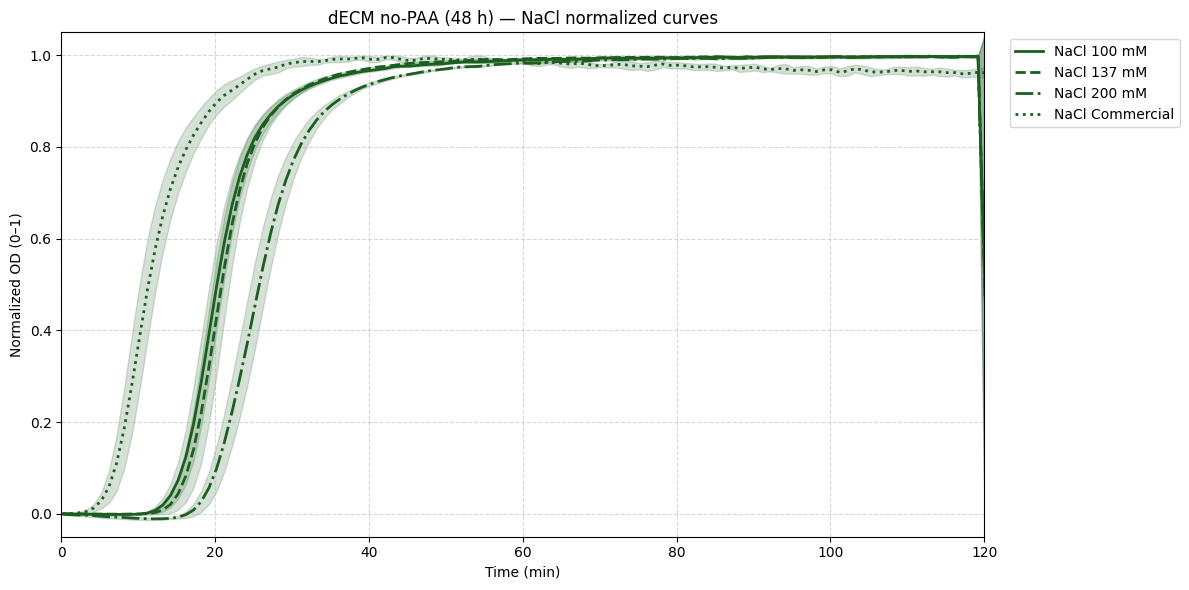

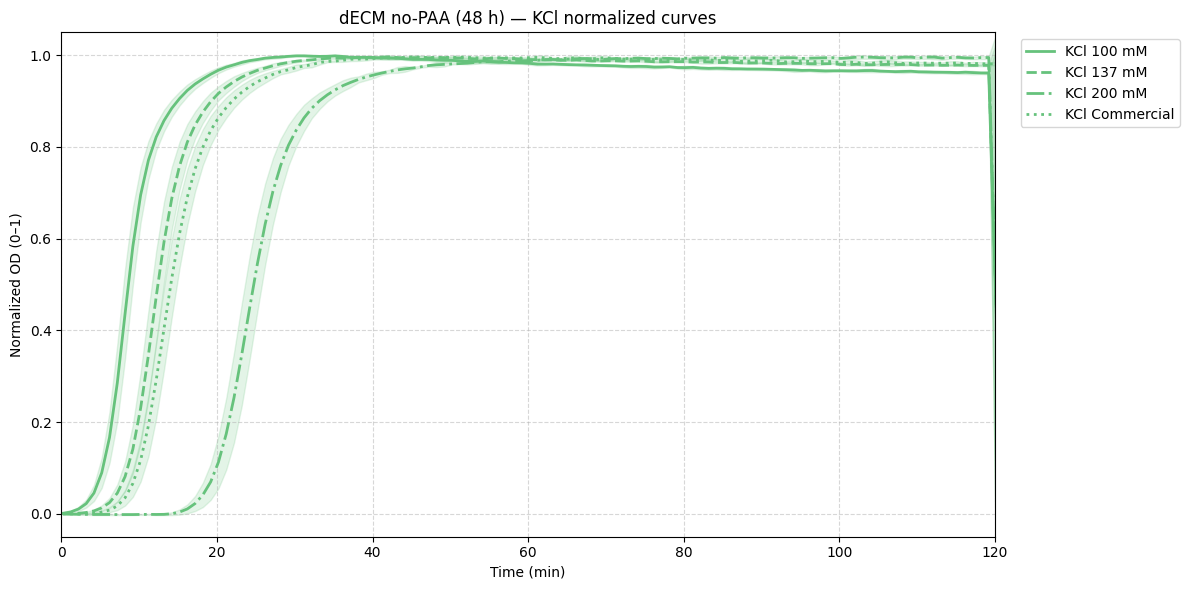

In [47]:
# --- Normalizar por pozo: (OD - OD0)/(ODmax - OD0)
def normalize_per_well(df_well):
    df_well = df_well.sort_values("time_min").copy()
    y0 = df_well["OD"].iloc[0]
    ymax = df_well["OD"].max()
    denom = ymax - y0
    if denom == 0:
        df_well["OD_norm"] = np.nan
    else:
        df_well["OD_norm"] = (df_well["OD"] - y0) / denom
    return df_well

norm_df = (
    long_df
    .groupby(["cond","well"], group_keys=False)
    .apply(normalize_per_well)
    .dropna(subset=["OD_norm"])
)

norm_summary = (
    norm_df
    .groupby(["salt","buffer","cond","time_min"])["OD_norm"]
    .agg(mean="mean", std="std")
    .reset_index()
)

# estilos: línea = buffer (concentración/comercial)
buffer_ls = {"100 mM":"-", "137 mM":"--", "200 mM":"-.", "Commercial":":"}

GREEN_APPLE = "#66c27c"   # KCl
GREEN_DARK  = "#1b5e20"   # NaCl
salt_color = {"NaCl": GREEN_DARK, "KCl": GREEN_APPLE}

def plot_norm_salt(salt):
    dfp = norm_summary[norm_summary["salt"] == salt].copy()
    order = [f"{salt} 100 mM", f"{salt} 137 mM", f"{salt} 200 mM", f"{salt} Commercial"]
    present = [c for c in order if c in dfp["cond"].unique()]

    plt.figure(figsize=(12,6))
    for cond in present:
        sub = dfp[dfp["cond"] == cond].sort_values("time_min")
        buf = sub["buffer"].iloc[0]
        plt.plot(sub["time_min"], sub["mean"],
                 color=salt_color[salt],
                 linestyle=buffer_ls.get(buf, "-"),
                 linewidth=2,
                 label=cond)
        plt.fill_between(sub["time_min"],
                         sub["mean"]-sub["std"],
                         sub["mean"]+sub["std"],
                         color=salt_color[salt], alpha=0.18)

    plt.title(f"dECM no-PAA (48 h) — {salt} normalized curves")
    plt.xlabel("Time (min)")
    plt.ylabel("Normalized OD (0–1)")
    plt.xlim(0,120)
    plt.ylim(-0.05,1.05)
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.legend(bbox_to_anchor=(1.02,1), loc="upper left")
    plt.tight_layout()
    plt.show()

plot_norm_salt("NaCl")
plot_norm_salt("KCl")


In [58]:
def plot_odmax_vs_conc(salt):
    dfp = odmax_well[odmax_well["salt"] == salt].copy()
    dfp["xcat"] = np.where(
        dfp["is_commercial"],
        "Commercial",
        dfp["conc_mM"].astype(int).astype(str)
    )

    stats = (
        dfp.groupby("xcat")["ODmax"]
        .agg(mean="mean", std="std", n="count")
        .reindex(["100","137","200","Commercial"])
        .dropna()
    )

    x = np.arange(len(stats.index))

    plt.figure(figsize=(6.6,4.5))
    plt.bar(
        x,
        stats["mean"],
        yerr=stats["std"],
        capsize=4,
        color=salt_color[salt],      # 🔹 COLOR AQUÍ
        alpha=0.85,
        edgecolor="black"
    )

    plt.xticks(x, stats.index)
    plt.xlabel("Concentration (mM) / Commercial")
    plt.ylabel("ODmax (raw)")
    plt.title(f"dECM no-PAA (48 h) — {salt} ODmax vs concentration")
    plt.ylim(0, 1.4)
    plt.grid(True, axis="y", linestyle="--", alpha=0.4)
    plt.tight_layout()
    plt.show()


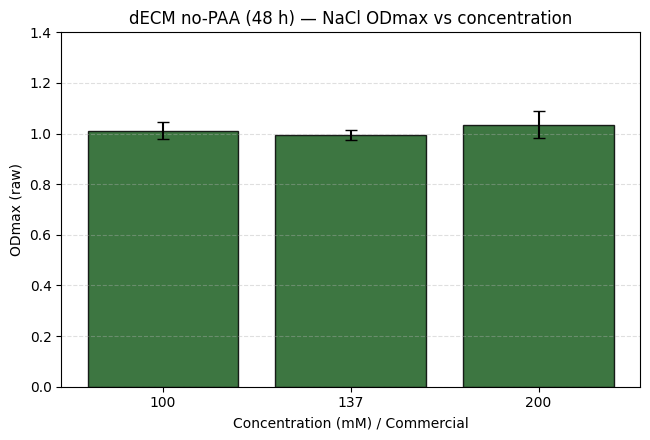

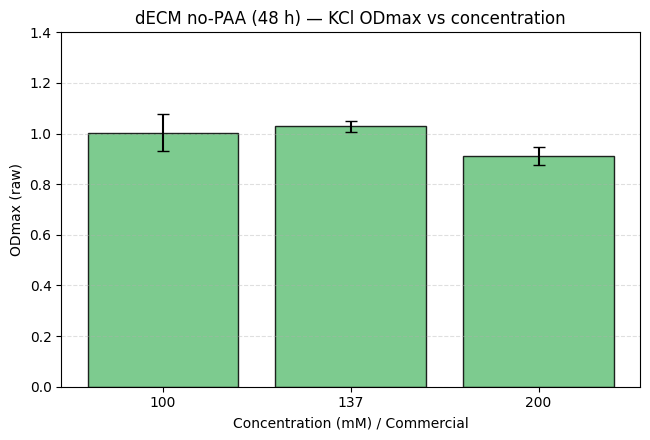

In [59]:
plot_odmax_vs_conc("NaCl")
plot_odmax_vs_conc("KCl")


In [55]:
print("norm_df rows:", len(norm_df))
print("speed_well rows:", len(speed_well))
print("speed_well NaNs:", speed_well["speed_max"].isna().sum(), " / ", len(speed_well))
print(speed_well.head())
print(speed_well.groupby(["salt","buffer"])["speed_max"].count())


norm_df rows: 6276
speed_well rows: 18
speed_well NaNs: 0  /  18
  salt  buffer  conc_mM  is_commercial well  speed_max
0  KCl  100 mM    100.0          False   A4        inf
1  KCl  100 mM    100.0          False   A5        inf
2  KCl  100 mM    100.0          False   A6        inf
3  KCl  137 mM    137.0          False   B4       -inf
4  KCl  137 mM    137.0          False   B5       -inf
salt  buffer
KCl   100 mM    3
      137 mM    3
      200 mM    3
NaCl  100 mM    3
      137 mM    3
      200 mM    3
Name: speed_max, dtype: int64


In [56]:
def max_slope_per_well(df_well):
    df_well = df_well.sort_values("time_min").copy()

    # Asegurar numérico
    df_well["time_min"] = pd.to_numeric(df_well["time_min"], errors="coerce")
    df_well = df_well.dropna(subset=["time_min","OD_norm"])

    # 🔥 Si hay tiempos repetidos, colapsarlos (esto suele ser la causa del "sin datos")
    df_well = df_well.groupby("time_min", as_index=False)["OD_norm"].mean()
    df_well = df_well.sort_values("time_min")

    t = df_well["time_min"].to_numpy()
    y = df_well["OD_norm"].to_numpy()

    if len(t) < 4:
        return np.nan

    dy_dt = np.gradient(y, t)

    # quedarnos con pendiente positiva (gelificación)
    dy_dt = dy_dt[np.isfinite(dy_dt)]
    dy_dt = dy_dt[dy_dt > 0]

    return np.nan if len(dy_dt) == 0 else float(np.max(dy_dt))

speed_well = (
    norm_df[norm_df["salt"].isin(["NaCl","KCl"])]
    .groupby(["salt","buffer","conc_mM","is_commercial","well"])
    .apply(max_slope_per_well)
    .reset_index(name="speed_max")
)

print("speed_well rows:", len(speed_well))
print("valid speeds:", speed_well["speed_max"].notna().sum())


speed_well rows: 18
valid speeds: 18


/tmp/ipython-input-1866047400.py:29: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(max_slope_per_well)


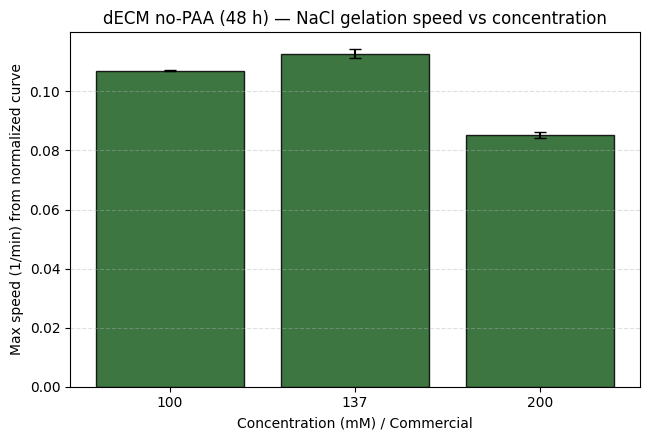

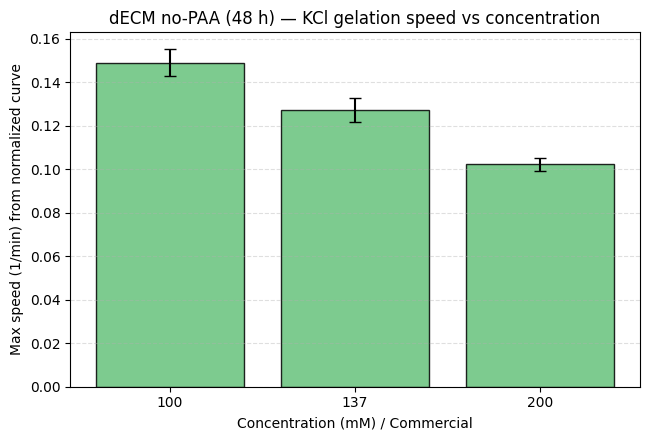

In [57]:
def plot_speed_vs_conc(salt):
    dfp = speed_well[(speed_well["salt"] == salt) & (speed_well["speed_max"].notna())].copy()

    if dfp.empty:
        print(f"⚠️ No hay speeds válidas para {salt}. Revisa norm_df / speed_well.")
        return

    dfp["xcat"] = np.where(dfp["is_commercial"], "Commercial", dfp["conc_mM"].astype(int).astype(str))

    stats = (
        dfp.groupby("xcat")["speed_max"]
        .agg(mean="mean", std="std", n="count")
        .reindex(["100","137","200","Commercial"])
        .dropna()
    )

    if stats.empty:
        print(f"⚠️ No hay stats tras agrupar para {salt}. Categorías disponibles:", dfp["xcat"].unique())
        return

    x = np.arange(len(stats.index))
    plt.figure(figsize=(6.6,4.5))
    plt.bar(
        x, stats["mean"], yerr=stats["std"], capsize=4,
        color=salt_color[salt], alpha=0.85, edgecolor="black"
    )
    plt.xticks(x, stats.index)
    plt.xlabel("Concentration (mM) / Commercial")
    plt.ylabel("Max speed (1/min) from normalized curve")
    plt.title(f"dECM no-PAA (48 h) — {salt} gelation speed vs concentration")
    plt.grid(True, axis="y", linestyle="--", alpha=0.4)
    plt.tight_layout()
    plt.show()

plot_speed_vs_conc("NaCl")
plot_speed_vs_conc("KCl")


In [60]:
print("RAW wells present (Commercial):")
print(long_df[long_df["buffer"]=="Commercial"].groupby(["salt","well"]).size())

print("\nNORM wells present (Commercial):")
print(norm_df[norm_df["buffer"]=="Commercial"].groupby(["salt","well"]).size())


RAW wells present (Commercial):
salt  well
KCl   D4      240
      D5      240
      D6      240
NaCl  D1      240
      D2      240
      D3      240
dtype: int64

NORM wells present (Commercial):
salt  well
KCl   D4      240
      D5      240
      D6      240
NaCl  D1      240
      D2      240
      D3      240
dtype: int64


In [61]:
odmax_well = (
    long_df[long_df["salt"].isin(["NaCl","KCl"])]
    .groupby(["salt","buffer","well"], as_index=False)["OD"]
    .max()
    .rename(columns={"OD":"ODmax"})
)

# xcat
odmax_well["xcat"] = np.where(
    odmax_well["buffer"].eq("Commercial"),
    "Commercial",
    odmax_well["buffer"].str.replace(" mM","", regex=False)
)


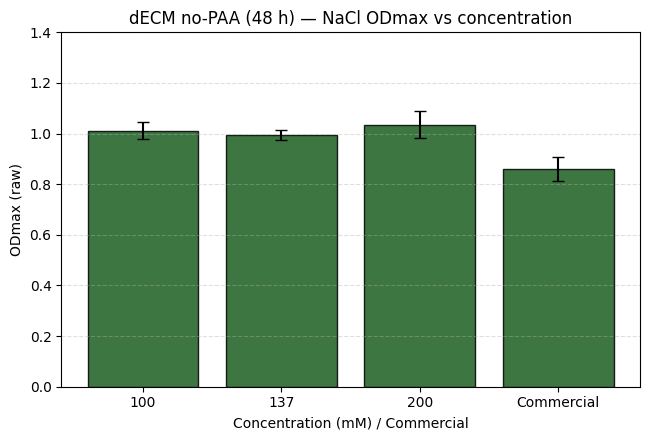

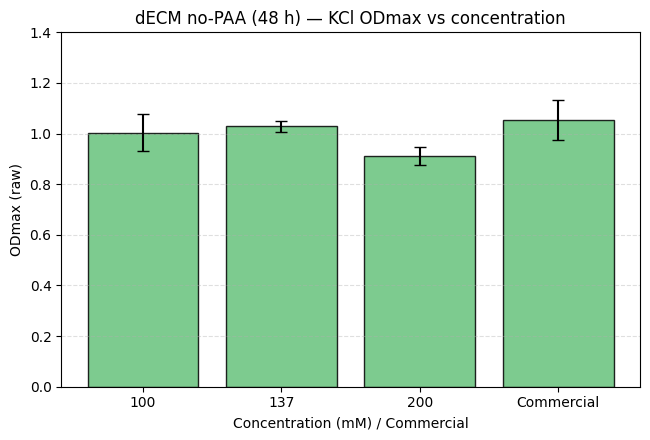

In [65]:
def plot_odmax_vs_conc(salt):
    dfp = odmax_well[odmax_well["salt"] == salt].copy()

    stats = (
        dfp.groupby("xcat")["ODmax"]
        .agg(mean="mean", std="std", n="count")
        .reindex(["100","137","200","Commercial"])
    )

    x = np.arange(len(stats.index))
    plt.figure(figsize=(6.6,4.5))
    plt.bar(
        x, stats["mean"], yerr=stats["std"], capsize=4,
        color=salt_color[salt], alpha=0.85, edgecolor="black"
    )
    plt.xticks(x, stats.index)
    plt.xlabel("Concentration (mM) / Commercial")
    plt.ylabel("ODmax (raw)")
    plt.title(f"dECM no-PAA (48 h) — {salt} ODmax vs concentration")
    plt.ylim(0, 1.4)
    plt.grid(True, axis="y", linestyle="--", alpha=0.4)
    plt.tight_layout()
    plt.show()

plot_odmax_vs_conc("NaCl")
plot_odmax_vs_conc("KCl")


In [63]:
def max_slope_per_well(df_well):
    df_well = df_well.sort_values("time_min").copy()
    df_well["time_min"] = pd.to_numeric(df_well["time_min"], errors="coerce")
    df_well = df_well.dropna(subset=["time_min","OD_norm"])

    df_well = df_well.groupby("time_min", as_index=False)["OD_norm"].mean()
    df_well = df_well.sort_values("time_min")

    t = df_well["time_min"].to_numpy()
    y = df_well["OD_norm"].to_numpy()
    if len(t) < 4:
        return np.nan

    dy_dt = np.gradient(y, t)
    dy_dt = dy_dt[np.isfinite(dy_dt)]
    dy_dt = dy_dt[dy_dt > 0]
    return np.nan if len(dy_dt) == 0 else float(np.max(dy_dt))

speed_well = (
    norm_df[norm_df["salt"].isin(["NaCl","KCl"])]
    .groupby(["salt","buffer","well"])
    .apply(max_slope_per_well)
    .reset_index(name="speed_max")
)

speed_well["xcat"] = np.where(
    speed_well["buffer"].eq("Commercial"),
    "Commercial",
    speed_well["buffer"].str.replace(" mM","", regex=False)
)


/tmp/ipython-input-2990412077.py:22: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(max_slope_per_well)


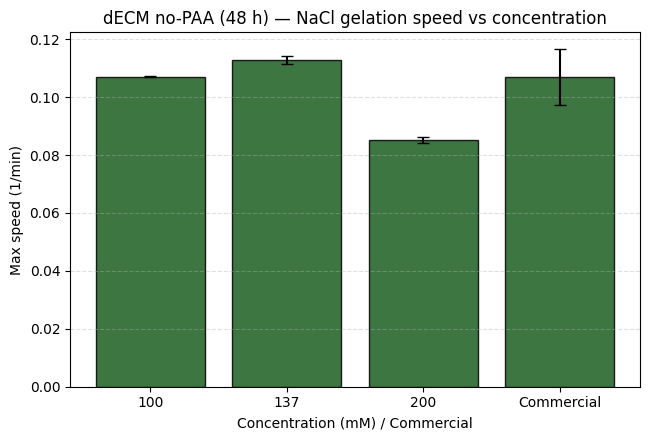

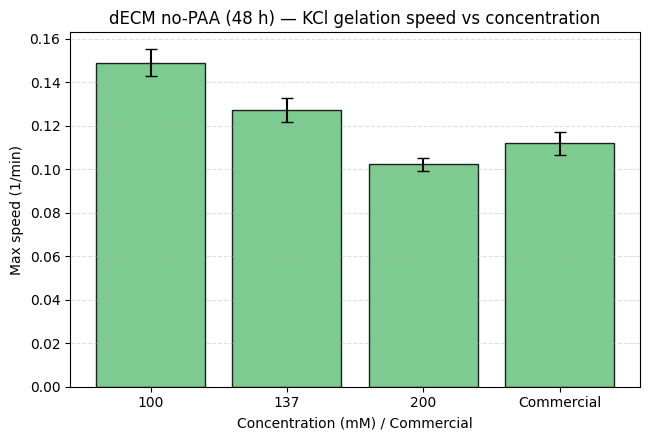

In [64]:
def plot_speed_vs_conc(salt):
    dfp = speed_well[(speed_well["salt"] == salt) & (speed_well["speed_max"].notna())].copy()

    stats = (
        dfp.groupby("xcat")["speed_max"]
        .agg(mean="mean", std="std", n="count")
        .reindex(["100","137","200","Commercial"])
    )

    x = np.arange(len(stats.index))
    plt.figure(figsize=(6.6,4.5))
    plt.bar(
        x, stats["mean"], yerr=stats["std"], capsize=4,
        color=salt_color[salt], alpha=0.85, edgecolor="black"
    )
    plt.xticks(x, stats.index)
    plt.xlabel("Concentration (mM) / Commercial")
    plt.ylabel("Max speed (1/min)")
    plt.title(f"dECM no-PAA (48 h) — {salt} gelation speed vs concentration")
    plt.grid(True, axis="y", linestyle="--", alpha=0.4)
    plt.tight_layout()
    plt.show()

plot_speed_vs_conc("NaCl")
plot_speed_vs_conc("KCl")
